## Importing Libraries

In [8]:
import os
import requests

import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
import pandas as pd

Mounted at /content/gdrive


## Loading Files from drive

In [0]:
PROJECT_DIR = "/content/gdrive/My Drive/Semester-2 Projects/ML Project/Person Identification"

In [5]:
!ls '$PROJECT_DIR/Recordings'

Adnan_Umer-12.csv  Adnan_Umer-3.csv  Ali_Shahid-5.csv	  Anas_Muhammad-2.csv
Adnan_Umer-15.csv  Adnan_Umer-4.csv  Ali_Shahid-6.csv	  Anas_Muhammad-3.csv
Adnan_Umer-17.csv  Ali_Shahid-1.csv  Ali_Shahid-7.csv	  Anas_Muhammad-4.csv
Adnan_Umer-18.csv  Ali_Shahid-2.csv  Ali_Shahid-8.csv
Adnan_Umer-1.csv   Ali_Shahid-3.csv  Ali_Shahid-9.csv
Adnan_Umer-2.csv   Ali_Shahid-4.csv  Anas_Muhammad-1.csv


## Sample size & stride

In [0]:
SAMPLE_SIZE = 50
STRIDE = SAMPLE_SIZE // 2
NUM_SENSORS = 6

## Visulaizing sensor values

In [0]:


def load_dataset(file_name):
    file_path = os.path.join(PROJECT_DIR, "Recordings", file_name)
    return pd.read_csv(file_path)


df = load_dataset("Adnan_Umer-18.csv")

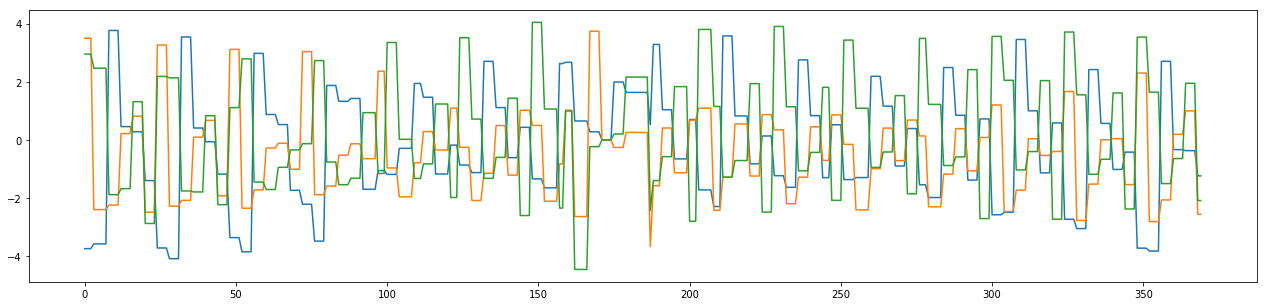

In [14]:
values = df.values.T


plt.figure(figsize=(22, 5))
plt.plot(values[0])
plt.plot(values[1])
plt.plot(values[2])

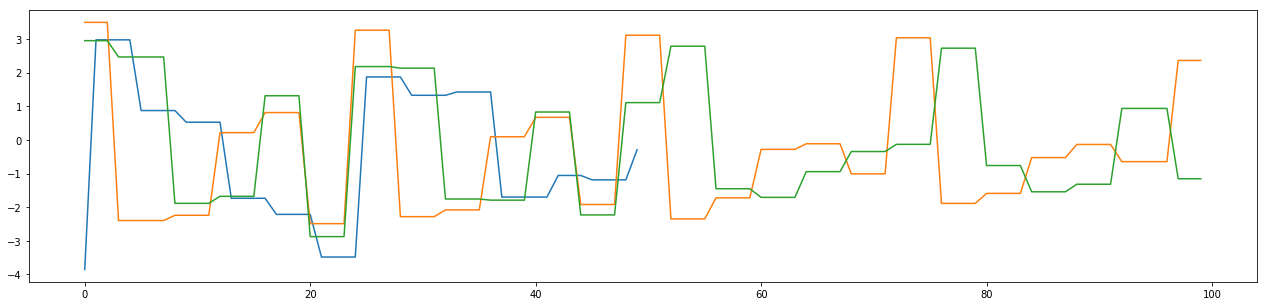

In [15]:
plt.figure(figsize=(22, 5))

plt.plot(values[0][55:105])
plt.plot(values[1][:100])
plt.plot(values[2][:100])

# plt.plot(values[3][:100])
# plt.plot(values[4][:100])
# plt.plot(values[5][:100])

### Taking Gradients of x,y,z axis of accelerometer

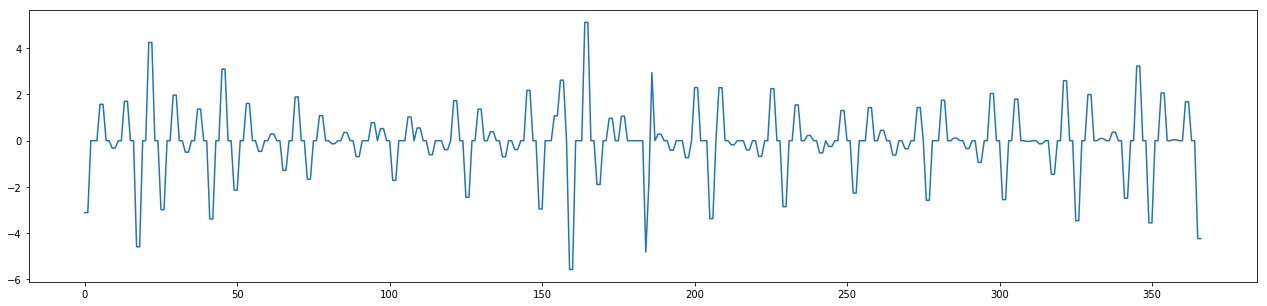

In [18]:
plt.figure(figsize=(22, 5))


dX = np.gradient(values[0])
dY = np.gradient(values[1])
dZ = np.gradient(values[2])

delta = np.sum([dX, dY, dZ], axis=0)
delta[(delta < 0.001) & (delta > -0.001)] = 0

delta = np.trim_zeros(delta, 'f')
delta = np.trim_zeros(delta, 'b')

plt.plot(delta)

### Creating Chunks of data

2


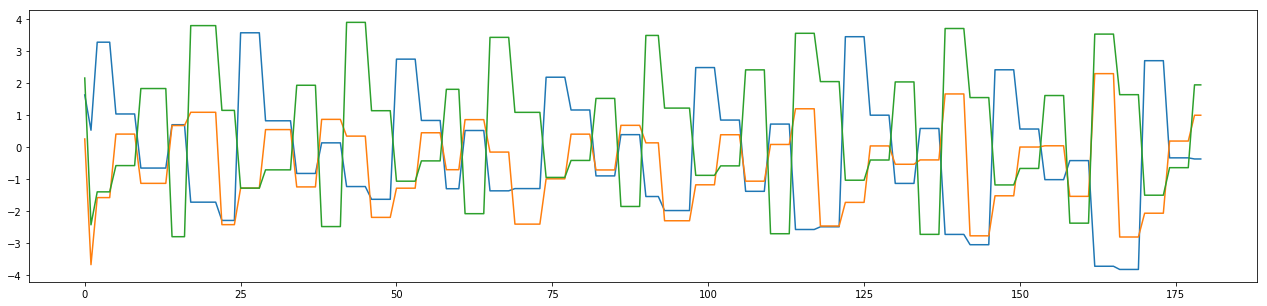

In [19]:
def split_on_non_activity(activity, d_threshold=0.001, interval_threshold=4):
    dX = np.gradient(values[0])
    dY = np.gradient(values[1])
    dZ = np.gradient(values[2])

    delta = np.sum([dX, dY, dZ], axis=0)
    delta[(delta < d_threshold) & (delta > -d_threshold)] = 0

    chunk_ranges = []
    zero_count = 0
    start_index = 0
    
    for i, v in enumerate(delta):
        if v == 0:
            zero_count += 1
            continue
            
        if zero_count >= interval_threshold:
            chunk = delta[start_index:i]
            start_index = i

            chunk = np.trim_zeros(chunk, 'b')
            if len(chunk) >= SAMPLE_SIZE:
                chunk_ranges.append((start_index, start_index + len(chunk)))

        zero_count = 0
        
    chunk = delta[start_index:]
    chunk = np.trim_zeros(chunk, 'b')
    if len(chunk) >= SAMPLE_SIZE:
        chunk_ranges.append((start_index, start_index + len(chunk)))
    
    return [
        values[:, start:end]
        for start, end in chunk_ranges
    ]


chunks = split_on_non_activity(values)

plt.figure(figsize=(22, 5))
print(len(chunks))
plt.plot(chunks[0][0])
plt.plot(chunks[0][1])
plt.plot(chunks[0][2])

## Creating Segmet from chunks given by sample size and stride

In [24]:
def create_segments(activity, sample_size, stride):
    return np.array([
        activity[:, i:i + sample_size].T
        for i in range(0, activity.shape[1] - sample_size, stride)
    ])


segments = create_segments(chunks[0], SAMPLE_SIZE, STRIDE)
segments.shape

(6, 50, 6)

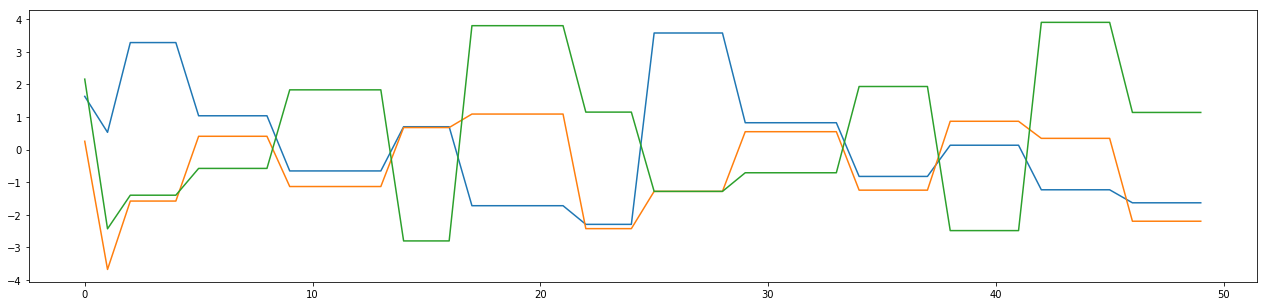

In [0]:
plt.figure(figsize=(22, 5))
plt.plot(segments[0, :, 0])
plt.plot(segments[0, :, 1])
plt.plot(segments[0, :, 2])

### Loading subject dataset and making segment of it

In [0]:
import glob


def load_subject_dataset(subject_name):
    recordings = []
    
    file_pattern = os.path.join(PROJECT_DIR, "Recordings", f"{subject_name}-*.csv")
    for f_path in glob.glob(file_pattern):
        filename = os.path.split(f_path)[1]
        recording = load_dataset(filename)
        chunks = split_on_non_activity(recording)
    
        for chunk in chunks:
            segments = create_segments(chunk, SAMPLE_SIZE, STRIDE)
            for segment in segments:
                recordings.append(segment.reshape((-1, *segment.shape)))

    return np.vstack(recordings)


C1 = load_subject_dataset("Anas_Muhammad")
C1.shape

(48, 50, 6)

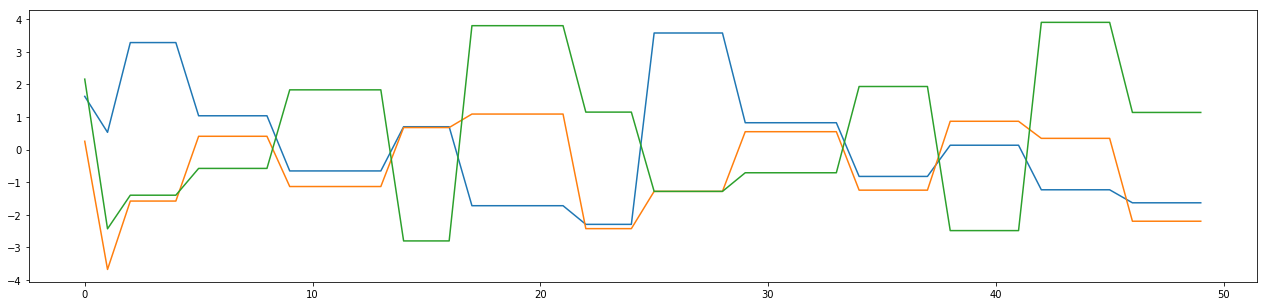

In [0]:
plt.figure(figsize=(22, 5))
plt.plot(C1[0, :, 0])
plt.plot(C1[0, :, 1])
plt.plot(C1[0, :, 2])

In [0]:
C2 = load_subject_dataset("Adnan_Umer")
C2.shape

(96, 50, 6)

In [0]:
C3 = load_subject_dataset("Ali_Shahid")
C3.shape

(108, 50, 6)

In [0]:
y = [0] * len(C1) + [1] * len(C2) + [2] * len(C3)

## training Data X with fearures of 50x6

In [0]:
X = np.vstack([C1, C2, C3])
X.shape

(252, 50, 6)

## Number of Classes

In [0]:
NUM_CLASSES = len(set(y))
NUM_CLASSES

3

## Neural Network

In [0]:
from keras.utils import np_utils


y_hot = np_utils.to_categorical(y, NUM_CLASSES)

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import (
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    Dense, Dropout, Activation, Flatten
)

K.clear_session()

model = Sequential()

model.add(Conv1D(8, 2, input_shape=(SAMPLE_SIZE, NUM_SENSORS)))
# model.add(Conv1D(8, 2, input_shape=(SAMPLE_SIZE, NUM_SENSORS)))
model.add(MaxPooling1D(3))
model.add(Conv1D(16, 8, activation='relu'))
# model.add(Conv1D(16, 8, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 49, 8)             104       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 16)             1040      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total para

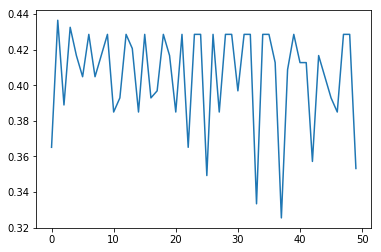

In [0]:
history = model.fit(
    x=X,
    y=y_hot,
    batch_size=32,
    epochs=50,
    verbose=0
)

plt.plot(history.history['acc'])

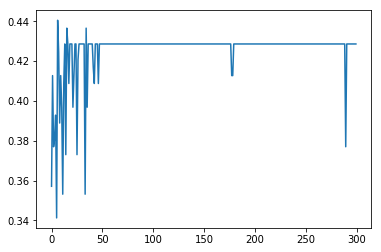

In [0]:
plt.plot(history.history['acc'])

In [0]:
model.evaluate(x=X, y=y_hot, batch_size=16, verbose=2) #loss and accuracy

[1.0460543572753294, 0.47368421052631576]

In [0]:
from sklearn import svm

## Checking with SVM

In [0]:
oneclass = svm.OneClassSVM(kernel='linear', gamma=0.001, nu=0.95)

In [25]:
segments = create_segments(values, 50, 2)
segments[:,:,0].shape

(160, 50)

In [26]:
segments = create_segments(values, 120, 10)
segments[:,:,0].shape


results = oneclass.fit_predict(segments[:,:,0])
print(np.sum(results == 1))
print(np.sum(results == -1))
print()

results = oneclass.predict(segments[:,:,1])
print(np.sum(results == 1))
print(np.sum(results == -1))

4
21

1
24
